In [2]:
import numpy as np

In [32]:
with open("ycsb_logs/load.log") as f:
    print(np.mean([int(l.strip().split()[-1]) for l in f.readlines() if "INSERT" in l and "99th" in l]))

438.8888888888889


In [34]:
with open("ycsb_logs_hugemapping/load.log") as f:
    print(np.mean([int(l.strip().split()[-1]) for l in f.readlines() if "INSERT" in l and "99th" in l]))

505.9222222222222


In [35]:
with open("ycsb_logs/run.log") as f:
    print(np.mean([int(l.strip().split()[-1]) for l in f.readlines() if "READ" in l and "99th" in l]))

842.9333333333333


In [37]:
with open("ycsb_logs/run.log") as f:
    print(np.mean([int(l.strip().split()[-1]) for l in f.readlines() if "READ" in l and "95th" in l]))

39.72222222222222


In [42]:
with open("ycsb_logs/run.log") as f:
    print(np.mean([float(l.strip().split()[-1]) for l in f.readlines() if "READ" in l and "Average" in l]))

36.41909937244014


In [36]:
with open("ycsb_logs_hugemapping/run.log") as f:
    print(np.mean([int(l.strip().split()[-1]) for l in f.readlines() if "READ" in l and "99th" in l]))

767.9444444444445


In [38]:
with open("ycsb_logs_hugemapping/run.log") as f:
    print(np.mean([int(l.strip().split()[-1]) for l in f.readlines() if "READ" in l and "95th" in l]))

42.861111111111114


In [41]:
with open("ycsb_logs_hugemapping/run.log") as f:
    print(np.mean([float(l.strip().split()[-1]) for l in f.readlines() if "READ" in l and "Average" in l]))

39.464968652315044


In [5]:
import polars as pl
from datetime import datetime
import time

In [6]:
def redis_timestamp_to_epoch(ts: str) -> float:
    #ts = "09 Dec 2025 23:40:54.060"
    # Parse using strptime — %f handles the milliseconds
    dt = datetime.strptime(ts, "%d %b %Y %H:%M:%S.%f")  # note two spaces before %H
    
    # Attach the local timezone
    local_dt = dt.replace(tzinfo=datetime.now().astimezone().tzinfo)
    
    # Convert to epoch seconds
    epoch = local_dt.timestamp()
    
    return epoch

In [7]:
from matplotlib import pyplot as plt

In [8]:
def get_proc_df(process_comm: str, file: str):
    proc_entries = []
    with open(file) as f:
        lines = f.readlines()
        
    display=False
    invocation_id = 0
    
    def get_entry(lines: list[str], idx: int, count: int, process_comm: str):
        while idx < len(lines) and "Accepted" not in lines[idx]:
            idx += 1
        if idx >= len(lines):
            return None
            
        line = lines[idx]
        start_s = redis_timestamp_to_epoch(line[4:].split('-')[0].strip())
        start_ns = int(start_s * 1000 * 1000 * 1000)
    
        while idx < len(lines) and "Connection reset" not in lines[idx]:
            idx += 1
        if idx >= len(lines):
            return None
    
        line = lines[idx]
        end_s = redis_timestamp_to_epoch(line[4:].split('-')[0].strip())
        end_ns = int(start_s * 1000 * 1000 * 1000)
        
        proc_entry = {"start_timestamp_ns": start_ns, "stop_timestamp_ns": end_ns, "count": count, "process_comm": process_comm}
        return proc_entry, idx
    
    idx = 0
    count = 0
    while True:
        res = get_entry(lines, idx, count, process_comm)
        if res is None:
            break
        proc_entry, idx = res
        count += 1
        proc_entries.append(proc_entry)

    return pl.from_dicts(proc_entries)


In [18]:
def get_rss_df(process_comm: str, file: str):
    entries = []
    with open(file) as f:
        lines = f.readlines()
    for line in lines:
        if "RSS=" not in line:
            continue
        try:
            now, _proc, _rss, n_pages = line.strip().split()
            now = float(now.split('=')[1][:-1])
            n_pages = int(n_pages.split('=')[1])
            now_ns = int(now * 1000 * 1000 * 1000)
        except Exception:
            continue
        
        entry = {"timestamp_ns": now_ns, "rss_bytes": n_pages * 4096, "process_comm": process_comm}
        entries.append(entry)
    return pl.from_dicts(entries)

In [10]:
get_proc_df("always_redis", "ycsb_logs_hugepage/server.log")

start_timestamp_ns,stop_timestamp_ns,count,process_comm
i64,i64,i64,str
1765361052588000000,1765361052588000000,0,"""always_redis"""
1765361064208999936,1765361064208999936,1,"""always_redis"""
1765361077736000000,1765361077736000000,2,"""always_redis"""
1765361089383000064,1765361089383000064,3,"""always_redis"""
1765361102537999872,1765361102537999872,4,"""always_redis"""
…,…,…,…
1765361202910000128,1765361202910000128,12,"""always_redis"""
1765361214543000064,1765361214543000064,13,"""always_redis"""
1765361228004999936,1765361228004999936,14,"""always_redis"""


In [28]:
hp_rss_df = get_rss_df("always_redis", "ycsb_logs_hugepage/server.log")
base_rss_df = get_rss_df("never_redis", "ycsb_logs/server.log")
map_rss_df = get_rss_df("idk_redis", "ycsb_logs_hugemapping/server.log")

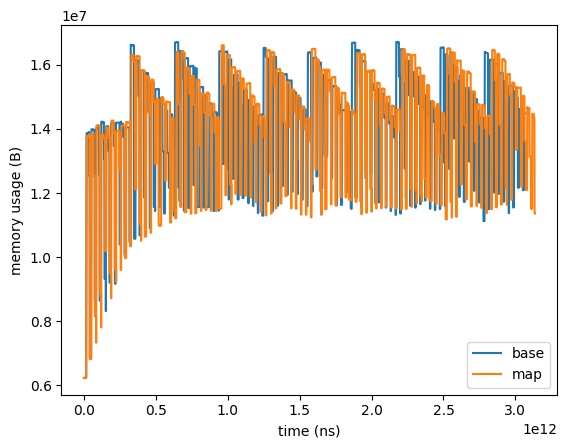

In [31]:
if False:
    rel_ts_hp = (hp_rss_df["timestamp_ns"] - hp_rss_df["timestamp_ns"][0])
    rel_ts_hp /= rel_ts_hp[-1]
    plt.plot(rel_ts_hp, hp_rss_df["rss_bytes"] - hp_rss_df["rss_bytes"][0], label="hugepage")

rel_ts_base = (base_rss_df["timestamp_ns"] - base_rss_df["timestamp_ns"][0])
# rel_ts_base /= rel_ts_base[-1]
plt.plot(rel_ts_base, base_rss_df["rss_bytes"], label="base")

rel_ts_map = (map_rss_df["timestamp_ns"] - map_rss_df["timestamp_ns"][0])
# rel_ts_map /= rel_ts_map[-1]
plt.plot(rel_ts_map, map_rss_df["rss_bytes"], label="map")

plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("memory usage (B)")
plt.savefig("idk.png")